### 1. 导入相关包

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


AttributeError: module 'tensorflow.python.util.dispatch' has no attribute 'add_fallback_dispatch_list'

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

### 2. 读取数据，简单进行处理

In [2]:
path = 'C:/Users/new/Desktop/Prediction-of-Containment-Events/数据/dataset.csv'
data = pd.read_csv(path)

In [3]:
data.head()

,日期,district,street,经停病例数,患者数量,全市患者数量,所在区患者数量,邻近地区1经停病例数,邻近地区2经停病例数,邻近地区3经停病例数,封控与否
0,2021/12/23 0:00,津南区,永胜道,31.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,2021/12/24 0:00,津南区,永胜道,42.0,0.0,0.0,0.0,2.0,0.0,3.0,0
2,2021/12/25 0:00,津南区,永胜道,36.0,0.0,0.0,0.0,2.0,0.0,4.0,0
3,2021/12/26 0:00,津南区,永胜道,46.0,0.0,0.0,0.0,4.0,2.0,3.0,0
4,2021/12/27 0:00,津南区,永胜道,73.0,0.0,0.0,0.0,4.0,2.0,2.0,0


In [6]:
data.drop(['district', 'street'], axis=1, inplace=True)
data.set_index('日期',inplace=True)

In [7]:
data.head()
data.info()

,经停病例数,患者数量,全市患者数量,所在区患者数量,邻近地区1经停病例数,邻近地区2经停病例数,邻近地区3经停病例数,封控与否
日期,,,,,,,,
2021/12/23 0:00,31.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2021/12/24 0:00,42.0,0.0,0.0,0.0,2.0,0.0,3.0,0
2021/12/25 0:00,36.0,0.0,0.0,0.0,2.0,0.0,4.0,0
2021/12/26 0:00,46.0,0.0,0.0,0.0,4.0,2.0,3.0,0
2021/12/27 0:00,73.0,0.0,0.0,0.0,4.0,2.0,2.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 34112 entries, 2021/12/23 0:00 to 2022/2/1 0:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   经停病例数       34112 non-null  float64
 1   患者数量        34112 non-null  float64
 2   全市患者数量      34112 non-null  float64
 3   所在区患者数量     34112 non-null  float64
 4   邻近地区1经停病例数  34112 non-null  float64
 5   邻近地区2经停病例数  34112 non-null  float64
 6   邻近地区3经停病例数  34112 non-null  float64
 7   封控与否        34112 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 2.3+ MB


### 3. 将数据处理成LSTM的数据输入格式：[batch_size, time_step, input_size]
在这里要注意，由于原始数据是所有street在 2021/12/23-2022/2/1 这段时间序列(length=41)的数据，不同street间的数据并没有时间上的相关性，因此需要划分为不同的样本

In [8]:
length = 41  # 每个镇区数据的时间序列长度都是41
split = int(len(data)*0.8) - int(len(data)*0.8) % length
train = data[:split]  # 相当于拿前面的大部分镇区数据做训练集，后面的小部分镇区做测试集了
test = data[split:]

In [9]:
train.head()
train.info()

,经停病例数,患者数量,全市患者数量,所在区患者数量,邻近地区1经停病例数,邻近地区2经停病例数,邻近地区3经停病例数,封控与否
日期,,,,,,,,
2021/12/23 0:00,31.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2021/12/24 0:00,42.0,0.0,0.0,0.0,2.0,0.0,3.0,0
2021/12/25 0:00,36.0,0.0,0.0,0.0,2.0,0.0,4.0,0
2021/12/26 0:00,46.0,0.0,0.0,0.0,4.0,2.0,3.0,0
2021/12/27 0:00,73.0,0.0,0.0,0.0,4.0,2.0,2.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 27265 entries, 2021/12/23 0:00 to 2022/2/1 0:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   经停病例数       27265 non-null  float64
 1   患者数量        27265 non-null  float64
 2   全市患者数量      27265 non-null  float64
 3   所在区患者数量     27265 non-null  float64
 4   邻近地区1经停病例数  27265 non-null  float64
 5   邻近地区2经停病例数  27265 non-null  float64
 6   邻近地区3经停病例数  27265 non-null  float64
 7   封控与否        27265 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1.9+ MB


In [10]:
test.head()
test.info()

,经停病例数,患者数量,全市患者数量,所在区患者数量,邻近地区1经停病例数,邻近地区2经停病例数,邻近地区3经停病例数,封控与否
日期,,,,,,,,
2021/12/23 0:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2021/12/24 0:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2021/12/25 0:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2021/12/26 0:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2021/12/27 0:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 6847 entries, 2021/12/23 0:00 to 2022/2/1 0:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   经停病例数       6847 non-null   float64
 1   患者数量        6847 non-null   float64
 2   全市患者数量      6847 non-null   float64
 3   所在区患者数量     6847 non-null   float64
 4   邻近地区1经停病例数  6847 non-null   float64
 5   邻近地区2经停病例数  6847 non-null   float64
 6   邻近地区3经停病例数  6847 non-null   float64
 7   封控与否        6847 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 481.4+ KB


In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [14]:
train
train.shape

array([[0.31 , 0.   , 0.   , 0.   , 0.   ],
       [0.42 , 0.   , 0.   , 0.   , 0.   ],
       [0.36 , 0.   , 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.148, 0.   , 0.   ],
       [0.   , 0.   , 0.148, 0.   , 0.   ],
       [0.   , 0.   , 0.252, 0.   , 0.   ]])

(27265, 5)

In [15]:
test
test.shape

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.148     , 0.00858369, 0.        ],
       [0.        , 0.        , 0.148     , 0.00858369, 0.        ],
       [0.        , 0.        , 0.252     , 0.01716738, 0.        ]])

(6847, 5)

In [16]:
def createXY(data, time_step):
    """
    将数据转化为LSTM数据输入格式: [batch_size, time_step, input_size]
    data: 数据
    time_step: 每条数据是time_step天作为一个整体去做预测
    """
    X, Y = [], []
    length = 41 # 一个镇区时间序列长度是41
    n = int(len(data) / length) # 其实就是总共有n个镇区的数据，镇区之间的数据不能连起来做一个样本
#     print(n)
    for i in range(n):
        offset = i * length       
        for j in range(time_step, length):
            X.append(data[j - time_step + offset:j + offset, :-1])
            Y.append(data[j + offset, -1]) # 最后一列是label Y，即封控与否
    return np.array(X), np.array(Y)

In [17]:
train_X, train_Y=createXY(train, 7) # 取time_step为7，即拿前7天的数据去推后1天的数据
test_X, test_Y=createXY(test, 7)

In [18]:
train_X
train_X.shape

array([[[0.31 , 0.   , 0.   , 0.   ],
        [0.42 , 0.   , 0.   , 0.   ],
        [0.36 , 0.   , 0.   , 0.   ],
        ...,
        [0.73 , 0.   , 0.   , 0.   ],
        [0.76 , 0.   , 0.   , 0.   ],
        [0.71 , 0.   , 0.   , 0.   ]],

       [[0.42 , 0.   , 0.   , 0.   ],
        [0.36 , 0.   , 0.   , 0.   ],
        [0.46 , 0.   , 0.   , 0.   ],
        ...,
        [0.76 , 0.   , 0.   , 0.   ],
        [0.71 , 0.   , 0.   , 0.   ],
        [0.72 , 0.   , 0.   , 0.   ]],

       [[0.36 , 0.   , 0.   , 0.   ],
        [0.46 , 0.   , 0.   , 0.   ],
        [0.73 , 0.   , 0.   , 0.   ],
        ...,
        [0.71 , 0.   , 0.   , 0.   ],
        [0.72 , 0.   , 0.   , 0.   ],
        [0.68 , 0.   , 0.   , 0.   ]],

       ...,

       [[0.   , 0.   , 0.216, 0.   ],
        [0.01 , 0.   , 0.132, 0.   ],
        [0.04 , 0.   , 0.104, 0.   ],
        ...,
        [0.05 , 0.   , 0.02 , 0.   ],
        [0.07 , 0.   , 0.044, 0.   ],
        [0.04 , 0.   , 0.084, 0.   ]],

       [[0.01 ,

(22610, 7, 4)

In [19]:
train_Y
train_Y.shape

array([0., 0., 0., ..., 0., 0., 0.])

(22610,)

In [21]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(7,4)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse', optimizer = optimizer)
    return grid_model

grid_model = KerasClassifier(build_fn=build_model,verbose=1,validation_data=(test_X,test_Y))

parameters = {'batch_size' : [4],
              'epochs' : [8, 10],
              'optimizer' : ['Adadelta'] }

grid_search  = GridSearchCV(estimator=grid_model, param_grid=parameters, cv = 3)

C:\Users\new\AppData\Local\Temp\ipykernel_40228\1945314889.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasClassifier(build_fn=build_model,verbose=1,validation_data=(test_X,test_Y))


In [22]:
grid_search = grid_search.fit(train_X,train_Y)

Epoch 1/8
3769/3769 [==============================] - 51s 12ms/step - loss: 4.3971e-04 - val_loss: 2.4221e-04
Epoch 2/8
3769/3769 [==============================] - 45s 12ms/step - loss: 3.3965e-04 - val_loss: 1.7367e-04
Epoch 3/8
3769/3769 [==============================] - 45s 12ms/step - loss: 2.8670e-04 - val_loss: 1.2935e-04
Epoch 4/8
3769/3769 [==============================] - 45s 12ms/step - loss: 2.5490e-04 - val_loss: 9.7301e-05
Epoch 5/8
3769/3769 [==============================] - 48s 13ms/step - loss: 2.2212e-04 - val_loss: 7.5190e-05
Epoch 6/8
3769/3769 [==============================] - 48s 13ms/step - loss: 1.9214e-04 - val_loss: 5.8755e-05
Epoch 7/8
3769/3769 [==============================] - 50s 13ms/step - loss: 1.7785e-04 - val_loss: 4.6251e-05
Epoch 8/8
1885/1885 [==============================] - 11s 5ms/step - loss: 0.0115


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


Epoch 1/8
3769/3769 [==============================] - 52s 13ms/step - loss: 0.0062 - val_loss: 8.1685e-05
Epoch 2/8
3769/3769 [==============================] - 49s 13ms/step - loss: 0.0060 - val_loss: 5.3363e-05
Epoch 3/8
3769/3769 [==============================] - 49s 13ms/step - loss: 0.0059 - val_loss: 4.4399e-05
Epoch 4/8
3769/3769 [==============================] - 49s 13ms/step - loss: 0.0059 - val_loss: 3.7009e-05
Epoch 5/8
3769/3769 [==============================] - 48s 13ms/step - loss: 0.0059 - val_loss: 3.0039e-05
Epoch 6/8
3769/3769 [==============================] - 50s 13ms/step - loss: 0.0059 - val_loss: 2.7897e-05
Epoch 7/8
3769/3769 [==============================] - 49s 13ms/step - loss: 0.0058 - val_loss: 2.6417e-05
Epoch 8/8
1885/1885 [==============================] - 12s 6ms/step - loss: 2.5304e-05
Epoch 1/8
3769/3769 [==============================] - 53s 13ms/step - loss: 0.0060 - val_loss: 1.9115e-04
Epoch 2/8
3769/3769 [==============================] - 46

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Epoch 1/8
5653/5653 [==============================] - 68s 12ms/step - loss: 0.0040 - val_loss: 1.6132e-04
Epoch 2/8
5653/5653 [==============================] - 65s 11ms/step - loss: 0.0040 - val_loss: 1.1405e-04
Epoch 3/8
5653/5653 [==============================] - 64s 11ms/step - loss: 0.0040 - val_loss: 8.4475e-05
Epoch 4/8
5653/5653 [==============================] - 64s 11ms/step - loss: 0.0039 - val_loss: 6.7803e-05
Epoch 5/8
5653/5653 [==============================] - 64s 11ms/step - loss: 0.0039 - val_loss: 5.5763e-05
Epoch 6/8
5653/5653 [==============================] - 68s 12ms/step - loss: 0.0039 - val_loss: 4.6209e-05
Epoch 7/8
5653/5653 [==============================] - 66s 12ms/step - loss: 0.0039 - val_loss: 3.8686e-05
Epoch 8/8
5653/5653 [==============================] - 65s 11ms/step - loss: 0.0039 - val_loss: 3.3520e-05


In [23]:
grid_search.best_params_

{'batch_size': 4, 'epochs': 8, 'optimizer': 'Adadelta'}

In [24]:
my_model = grid_search.best_estimator_.model

In [25]:
prediction=my_model.predict(test_X)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

178/178 [==============================] - 1s 4ms/step
prediction
 [[ 0.00039353]
 [ 0.00037467]
 [ 0.00035569]
 ...
 [-0.00043297]
 [ 0.00025874]
 [ 0.00076367]]

Prediction Shape- (5678, 1)


In [26]:
test_Y.shape

(5678,)

In [27]:
prediction.shape

(5678, 1)

Text(0.5, 1.0, 'Containment events Prediction')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Possibility of Containment')

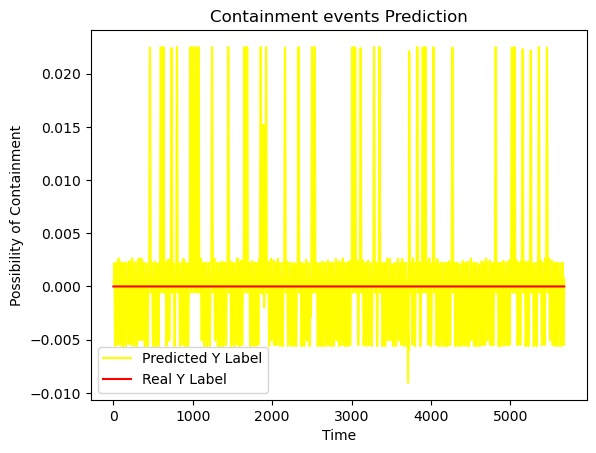

In [32]:
plt.plot(prediction, color = 'yellow', label = 'Predicted Y Label')
plt.plot(test_Y, color = 'red', label = 'Real Y Label')
plt.title('Containment events Prediction')
plt.xlabel('Time')
plt.ylabel('Possibility of Containment')
plt.legend()
plt.show()